## External AIS Data Analysis

Source: https://hub.marinecadastre.gov/pages/vesseltraffic

Downloaded: 2024-01-01 dataset for EDA purpose

Notes:
* Some unknown columns: 'IMO', 'CallSign', 'Status','Draft', 'Cargo'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import sys, os

sys.path.append(os.path.abspath('..'))

from core.DICT import CODE2TYPE

# Define file paths
ais = pd.read_csv('../../data/external_ais/AIS_2024_01_01.csv')
radar_detections = pd.read_csv('../../data/cleaned_data/preprocessed_radar_detections.csv')

In [3]:
ais.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,338075892,2024-01-01T00:00:03,43.65322,-70.25298,0.0,358.8,511.0,PILOT BOAT SPRING PT,NaN,WDB8945,90.0,0.0,0.0,0.0,0.0,90.0,A
1,367669550,2024-01-01T00:00:04,46.20031,-123.38573,0.0,281.9,141.0,ALASKA CHALLENGER,IMO7938024,WDH9586,30.0,15.0,30.0,8.0,0.0,30.0,A
2,367118980,2024-01-01T00:00:06,29.98534,-90.40674,0.0,30.1,296.0,CAPT J A MORGAN,IMO1186680,WDD2725,31.0,12.0,115.0,34.0,3.0,57.0,A
3,367177840,2024-01-01T00:00:05,39.88654,-75.17649,0.0,304.4,511.0,BART TURECAMO,IMO7338808,WBR4464,52.0,15.0,33.0,5.0,0.0,52.0,A
4,367305420,2024-01-01T00:00:06,18.33273,-64.95229,0.0,332.6,511.0,DOROTHY MORAN,IMO7716995,WXU4654,52.0,0.0,33.0,11.0,0.0,52.0,A


In [ ]:
#Some preprocessing
ais['datetime'] = pd.to_datetime(ais.loc[:,'BaseDateTime'])

#mmsi: actually corresponds to id_vessel, to bre precise
ais.rename(columns={
    'MMSI':'id_track', 
    'LAT':'latitude', 
    'LON':'longitude',
    'SOG': 'speed',
    'COG': 'course'
    }, inplace=True)

ais['type_m2'] = ais['VesselType'].map(CODE2TYPE)
ais.drop(columns = ['BaseDateTime', 'VesselType', 'IMO', 'CallSign', 'Status', 'Length', 'Width', 'Draft', 'Cargo'], inplace=True)
print(ais.columns)

Index(['id_track', 'latitude', 'longitude', 'speed', 'course', 'Heading',
       'VesselName', 'TransceiverClass', 'datetime', 'type_m2'],
      dtype='object')


### EDAs

In [5]:
#this is just 2024-01-01 data!!
print(f'Total number of detection points: {len(ais)}')
print(f'Total number of vessels: {len(ais["id_track"].unique())}')

Total number of detection points: 7296275
Total number of vessels: 14868


In [6]:
unique = ais.drop_duplicates(subset=['id_track'], keep='first')

unique['TransceiverClass'].value_counts()

TransceiverClass
B    7444
A    7424
Name: count, dtype: int64

In [7]:
#notice class B vessel here is more granular than our provided dataset!
unique[unique['TransceiverClass'] == 'B'].head(3)

,id_track,latitude,longitude,speed,course,Heading,VesselName,TransceiverClass,datetime,type_m2
5,338239081,38.95731,-76.48410,0.1,111.3,511.0,JAHAZI,B,2024-01-01 00:00:05,sailboat
86,368261890,34.21487,-77.81431,0.0,357.4,511.0,TIME-LAPSE,B,2024-01-01 00:00:07,pleasure_craft
87,367668570,48.75516,-122.50379,0.0,360.0,511.0,VIKING LEADER,B,2024-01-01 00:00:08,fishing_boat


### Trajectory Plot

In [29]:
#helper plotting function

def plot_trajectory(track_data, start = 0, end = 1):
    """
    Args:
        track_data: pd dataframe; detections associated with 1 track
    """
    assert len(track_data['id_track'].unique()) == 1, "track_data must be associated with 1 track"

    track_id = track_data['id_track'].iloc[0]  # Ensure we grab the first element of the track id
    track_data = track_data.sort_values('datetime')

    #plot only a portion of the data
    nrows = len(track_data)
    start_row = int(nrows * start)
    end_row = int(nrows * end)
    track_data = track_data.iloc[start_row:end_row]

    # Calculate duration
    start_time = track_data['datetime'].iloc[0]
    end_time = track_data['datetime'].iloc[-1]
    duration = end_time - start_time
    total_seconds = int(duration.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    duration_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

    # Create figure and axis for a single plot
    fig, ax = plt.subplots(figsize=(5, 4))

    # Plot trajectory
    ax.plot(track_data['longitude'], track_data['latitude'], 
            marker='o', markersize=2, linewidth=1, alpha=0.6)

    # Add start and end points
    ax.scatter(track_data['longitude'].iloc[0], track_data['latitude'].iloc[0], 
                color='green', marker='^', s=100, label='Start')
    ax.scatter(track_data['longitude'].iloc[-1], track_data['latitude'].iloc[-1], 
                color='red', marker='v', s=100, label='End')

    # Customize plot
    ax.set_title(f'Track {track_id}\nDuration: {duration_str}\nNumber of detections: {end_row - start_row}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    ax.legend()
    plt.xticks(rotation=45)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


In [36]:
ais['id_track'].sample(10)

6638167    368243880
6336637    367437150
267897     311001095
442985     338561000
2151163    338238572
1828391    366951730
1185669    368196090
5226375    366831470
2152263    368310310
818702     366927640
Name: id_track, dtype: int64

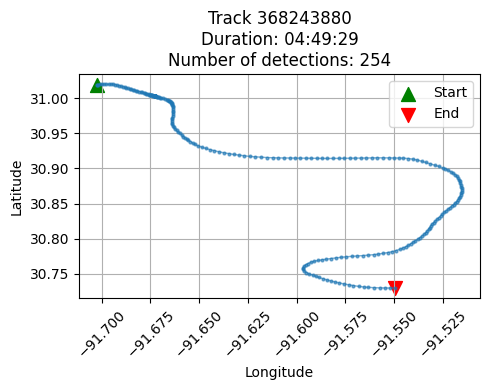

In [39]:
#normal track example
track = ais[ais['id_track'] == 368243880]
plot_trajectory(track, 0, 0.2)

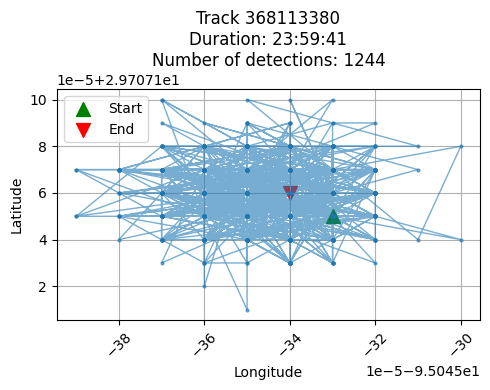

In [35]:
#stopped track example: looks like discretized but its actually stopped
#note x,y axis scales are 1e-5 magnitude
track = ais[ais['id_track'] == 368113380]
plot_trajectory(track)

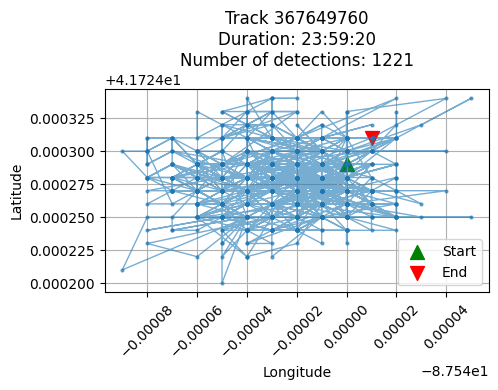

In [ ]:
#another stopped
track = ais[ais['id_track'] == 367649760]
plot_trajectory(track)

### Test XGboost Activity Model

In [ ]:
#preprocess to remove disrupted tracks
from core.preprocess import DisruptionFilter

#only less than 1% removed: great!
valid_detections = DisruptionFilter(ais)()
print(valid_detections['id_track'].nunique())

In [44]:
from core.sum_stats import SumStatsBaseline

summary_df = SumStatsBaseline(valid_detections)()
summary_df

/Users/liuzehan/Desktop/Protected Seas/peter/core/sum_stats.py:250: RuntimeWarning: invalid value encountered in scalar divide
  curviness = total_distance / distance_o
/Users/liuzehan/Desktop/Protected Seas/peter/core/sum_stats.py:250: RuntimeWarning: invalid value encountered in scalar divide
  curviness = total_distance / distance_o
/Users/liuzehan/Desktop/Protected Seas/peter/core/sum_stats.py:250: RuntimeWarning: invalid value encountered in scalar divide
  curviness = total_distance / distance_o
/Users/liuzehan/Desktop/Protected Seas/peter/core/sum_stats.py:250: RuntimeWarning: invalid value encountered in scalar divide
  curviness = total_distance / distance_o
/Users/liuzehan/Desktop/Protected Seas/peter/core/sum_stats.py:240: RuntimeWarning: invalid value encountered in sqrt
  std_heading = np.sqrt(-np.log(meanCos*meanCos + meanSin*meanSin))
/Users/liuzehan/Desktop/Protected Seas/peter/core/sum_stats.py:250: RuntimeWarning: invalid value encountered in scalar divide
  curviness

,id_track,duration,distance_total,detections,max_speed,min_speed,avg_speed,heading_mean,heading_std,turning_mean,turning_std,distance_o,curviness
0,0,0 days 23:56:00,0.452742,396,0.0,0.0,0.000000,152.983020,0.408242,23.482785,79.106009,0.005186,87.297544
1,4061,0 days 19:56:59,0.030307,7,0.1,0.0,0.014286,-20.764018,0.865723,56.633333,52.390383,0.008849,3.424882
2,3381234,0 days 23:57:07,2.005301,349,1.2,0.0,0.407736,9.775364,1.092115,30.389943,65.162759,0.095642,20.966635
3,3660489,0 days 20:59:59,0.203439,30,0.1,0.0,0.006667,97.749712,2.218505,60.862069,88.214755,0.022327,9.111997
4,4556531,0 days 00:00:00,0.000000,1,2.3,2.3,2.300000,70.700000,-0.000000,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14749,985380251,0 days 00:32:56,9.727201,4,11.6,5.3,8.075000,-142.138040,0.177896,17.200000,7.965342,9.722940,1.000438
14750,987654321,0 days 23:54:00,0.072320,238,0.0,0.0,0.000000,-109.426087,2.032133,112.529536,86.235771,0.001848,39.136261
14751,993086011,0 days 00:11:00,0.188410,4,1.4,0.9,1.075000,-122.184592,1.906465,73.966667,74.484018,0.111040,1.696777
14752,999999999,0 days 00:00:00,0.000000,1,6.3,6.3,6.300000,1.200000,-0.000000,NaN,NaN,0.000000,NaN
